In [13]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output

from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', size=30)

In [14]:
dataset_train = CIFAR10('cifar10', train=True, download = True)

Files already downloaded and verified


In [15]:
dataset_train[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

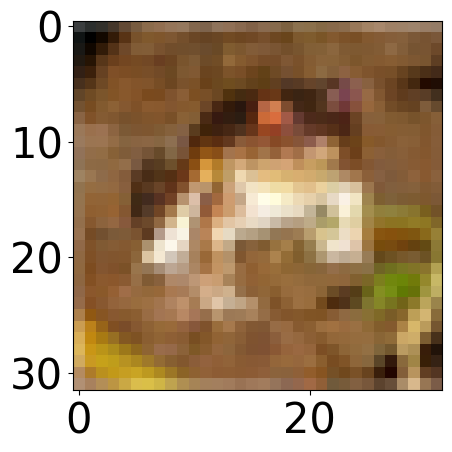

In [16]:
plt.imshow(dataset_train[0][0])
plt.show()

In [17]:
img_matrix = np.array(dataset_train[0][0]) / 255

img_matrix.shape

(32, 32, 3)

In [18]:
dataset_train = CIFAR10('cifar10',
                        train=True, 
                        transform=T.ToTensor())

Normalization

In [19]:
dataset_train.data.shape

(50000, 32, 32, 3)

In [20]:
means = (dataset_train.data / 255).mean(axis=(0, 1, 2))

means

array([0.49139968, 0.48215841, 0.44653091])

In [21]:
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

stds

array([0.24703223, 0.24348513, 0.26158784])

In [22]:
transforms = T.Compose(
    [
        T.ToTensor(), #transform to tensor
        T.Normalize(mean=means, std=stds) #normalization
    ]
)

In [23]:
train_dataset = CIFAR10('cifar10', train=True, transform=transforms)
valid_dataset = CIFAR10('cifar10', train=False, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

Let's create a function for training the model

In [24]:
def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

Let's create a function to evaluate the model

In [25]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

Let's create a function once to correctly display the resulting graphs

In [26]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [27]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model) #model training
        valid_loss, valid_accuracy = evaluate(model, valid_loader) #evaluation

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        ) #plot the results

# First Model

let's try a very simple model which consists of:
- 2 convolutional layer
- max pooling
- 3 linear

In [28]:
class FirstModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 32 x 32 x 16
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 16 x 16 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32

            nn.Flatten(),

            nn.Linear(8 * 8 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

loss_fn = nn.CrossEntropyLoss() #loss function

cuda:0


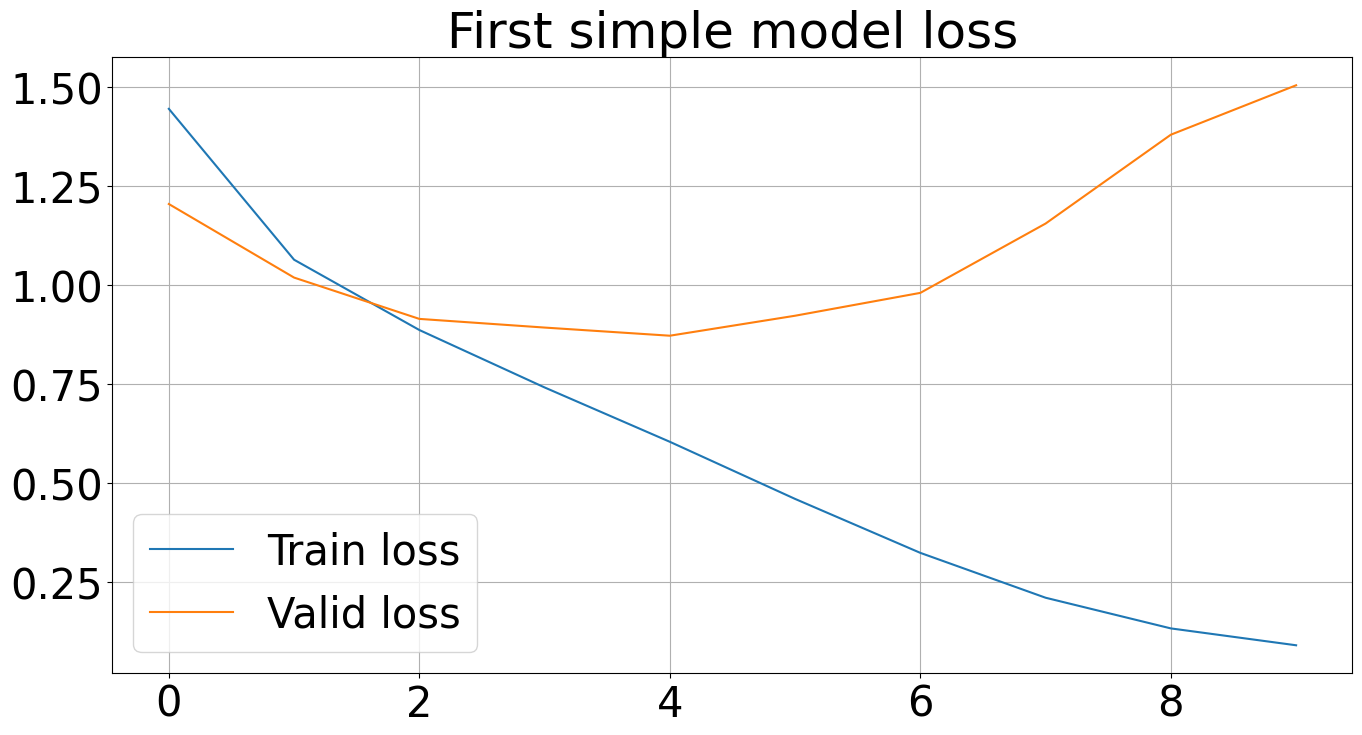

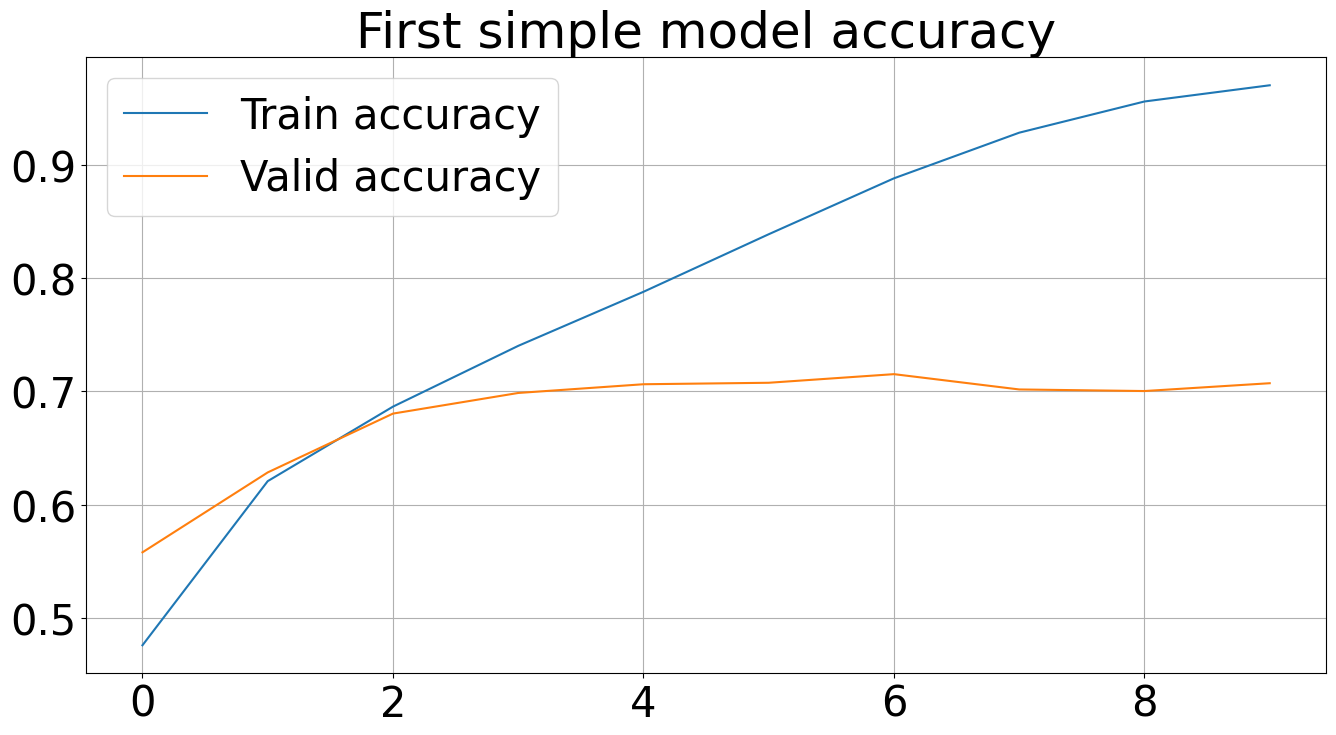

In [30]:
model = FirstModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3) #adaptive moment estimation

whole_train_valid_cycle(model, 10, 'First simple model')

# Second Model

let's try to complicate the model:
- 6 convolutional layer
- 3 max pooling
- 2 linear

In [31]:
class SecondModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

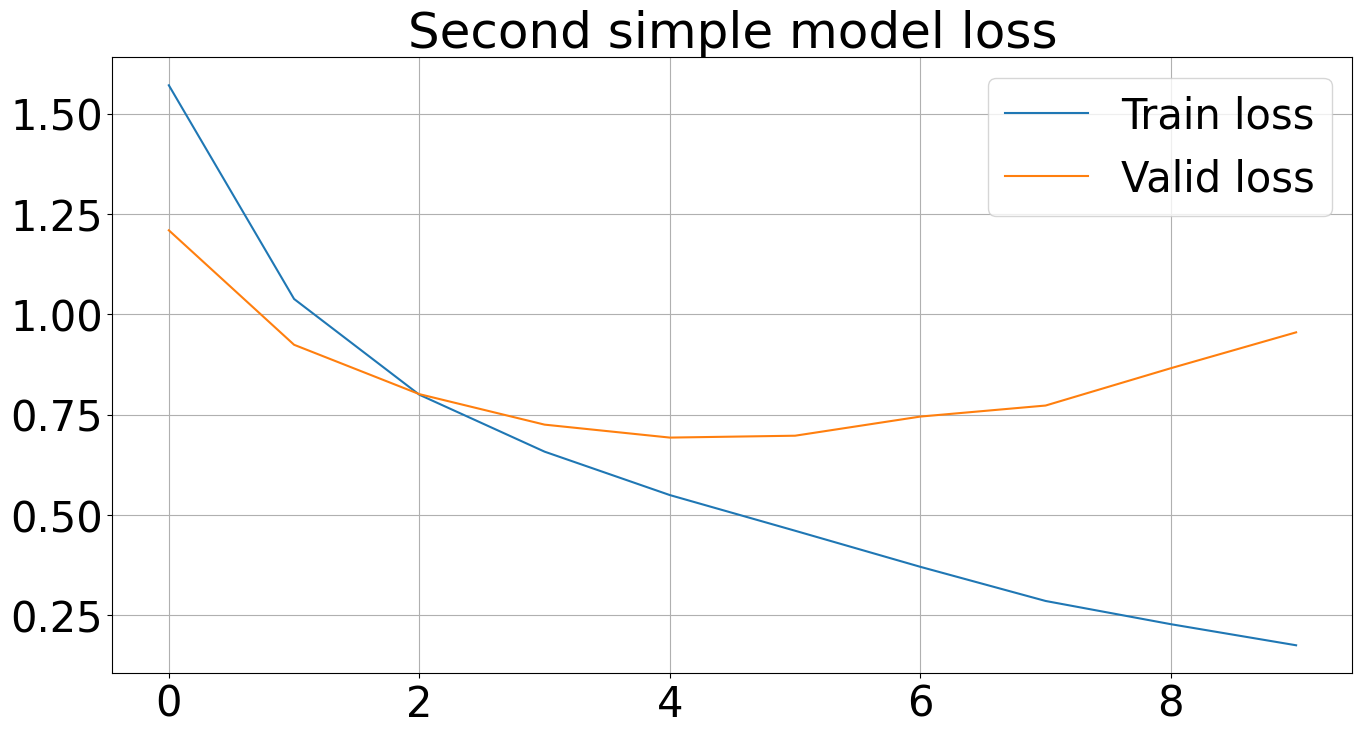

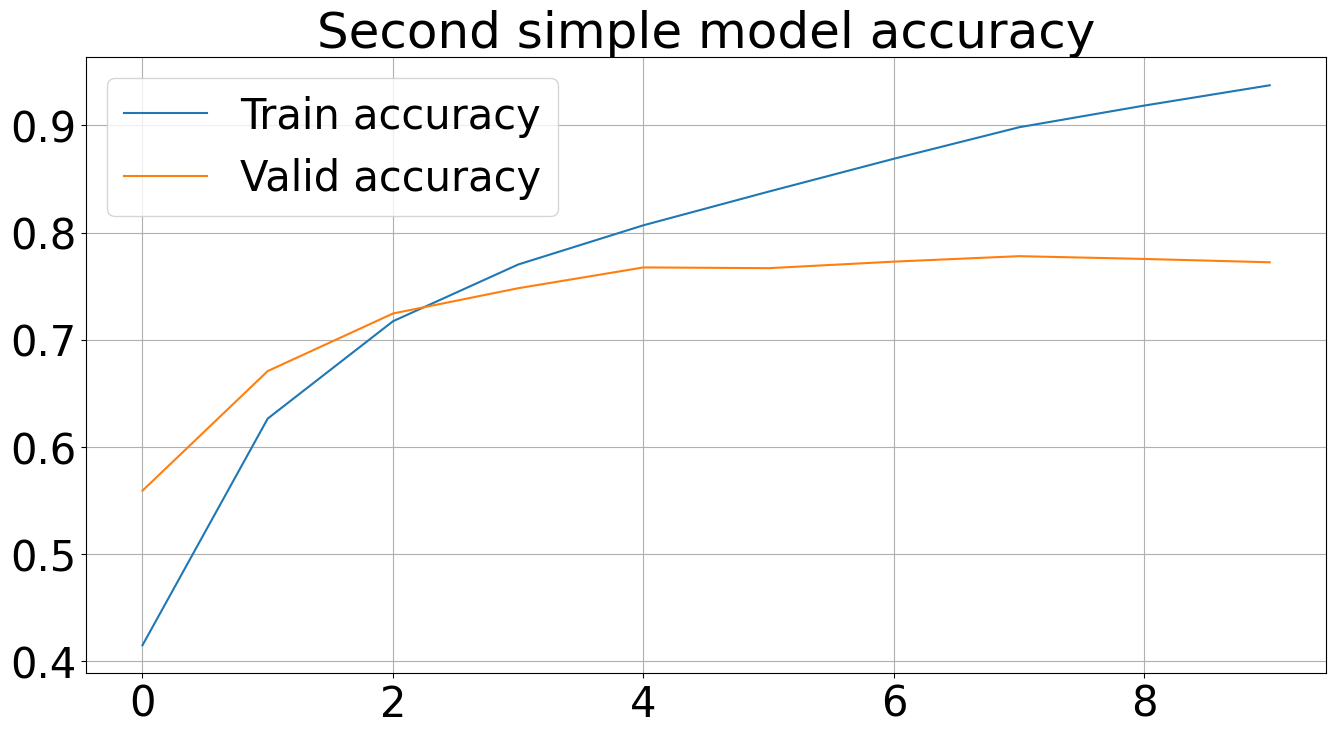

In [32]:
model = SecondModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3) #adaptive moment estimation

whole_train_valid_cycle(model, 10, 'Second simple model')

# Third Model

let's complicate the model a little more:
- 6 convolutional layer
- 3 max pooling
- 7 batch normalization
- 2 linear

In [33]:
class ThirdModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

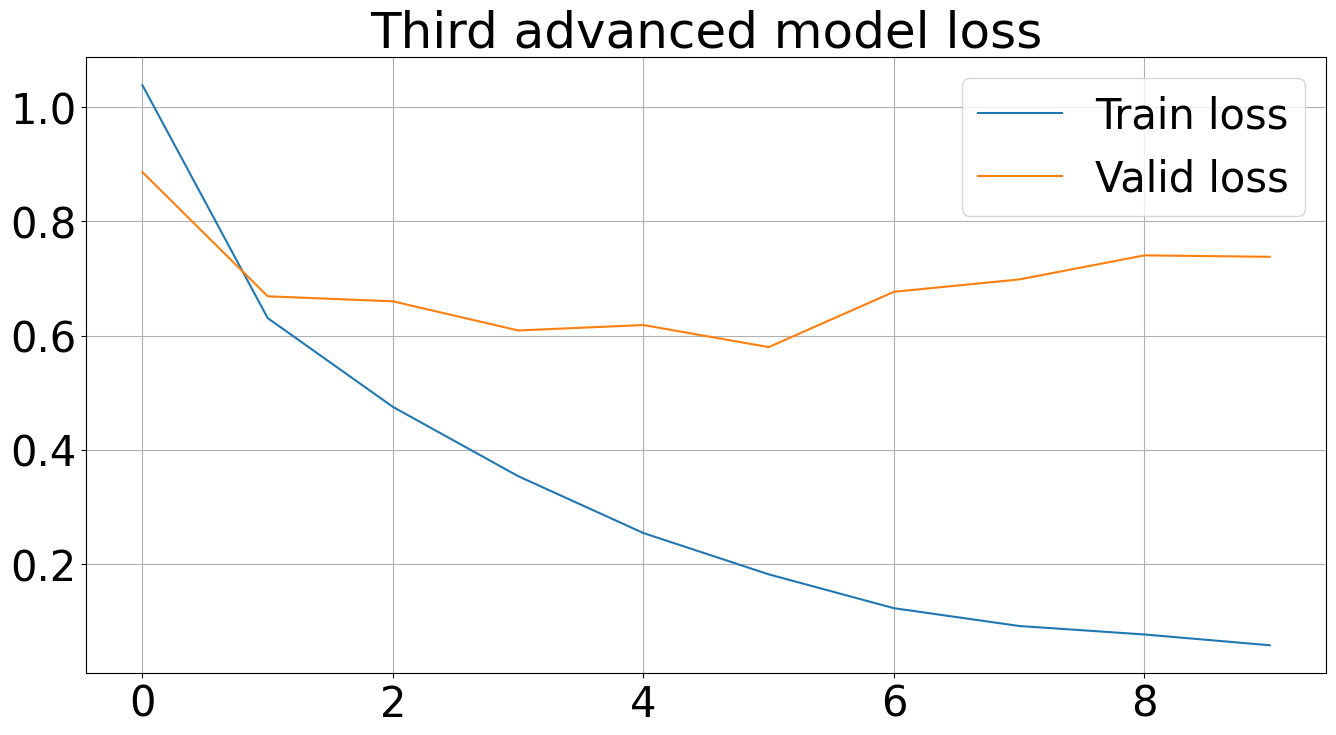

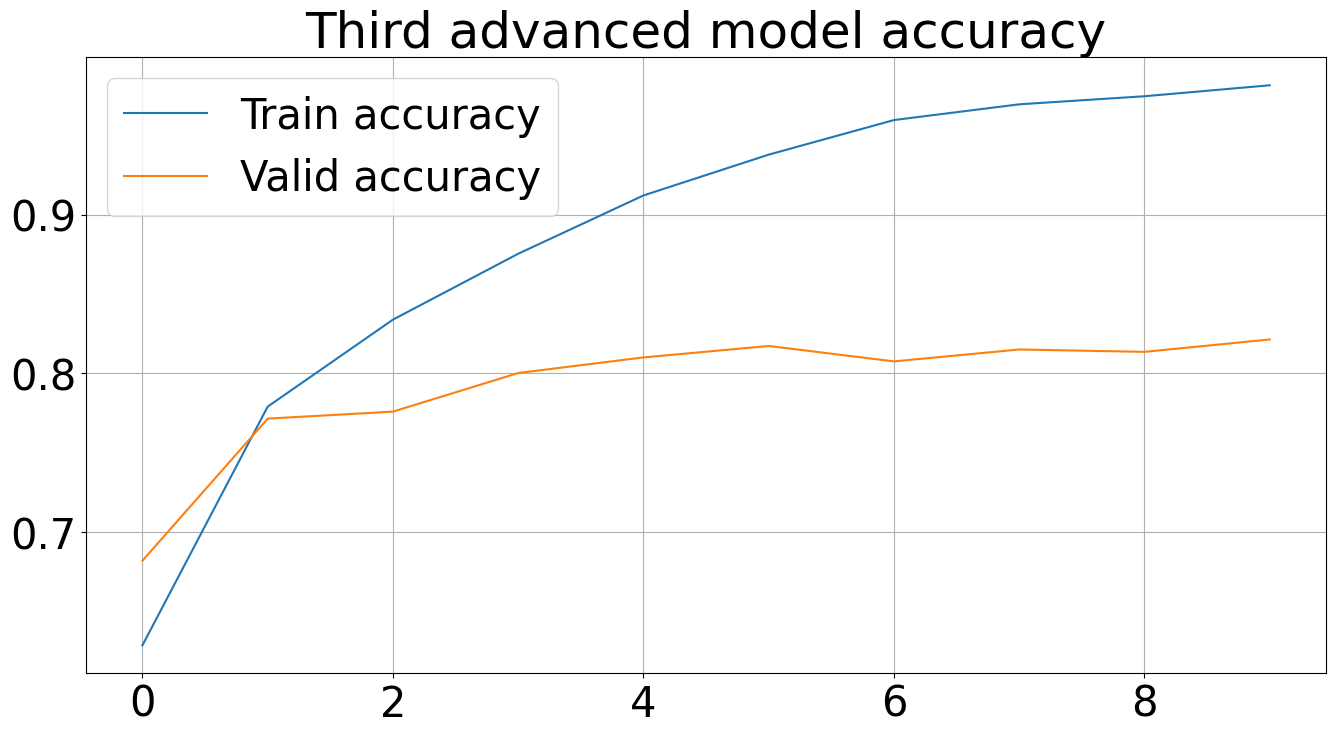

In [34]:
model = ThirdModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'Third advanced model')

# Fourth Model

let's complicate the model a little more:
- 6 convolutional layer
- 3 max pooling
- 7 batch normalization 
- 2 linear
- 4 dropout (for regularization NN)

In [35]:
class FourthModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

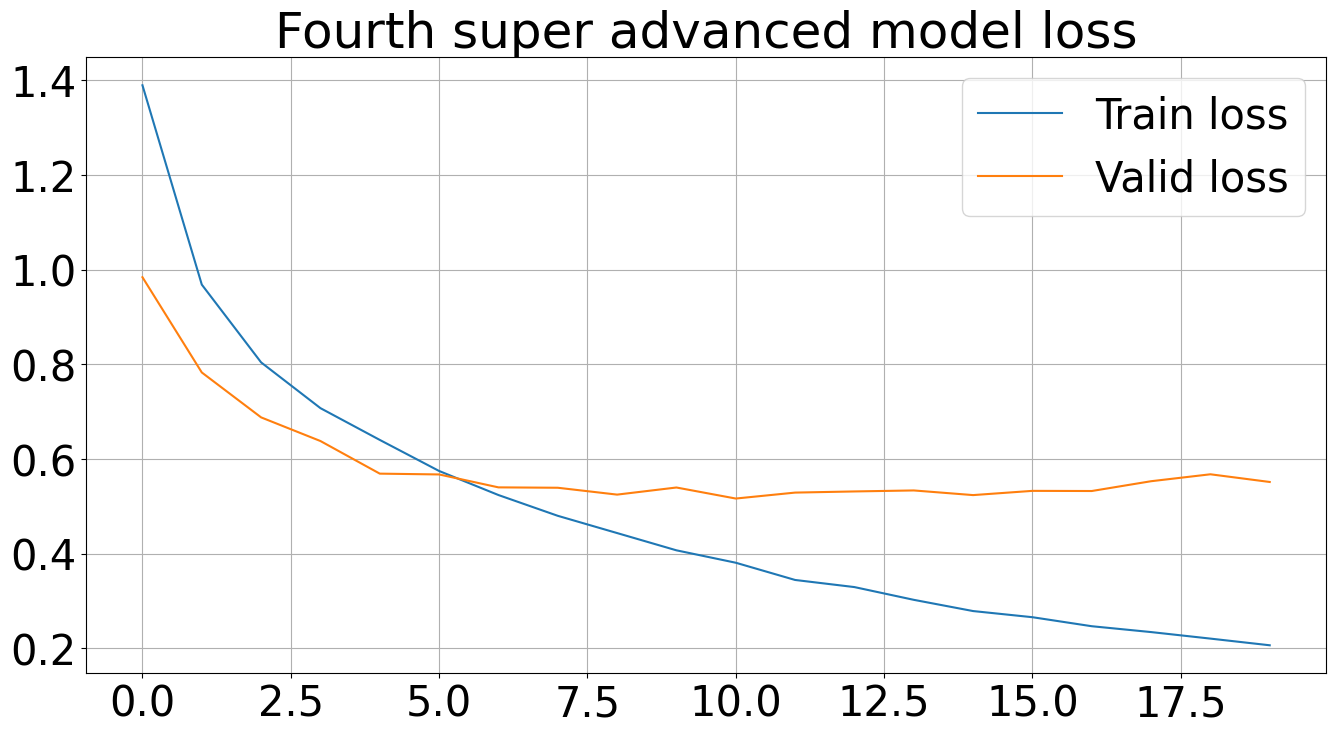

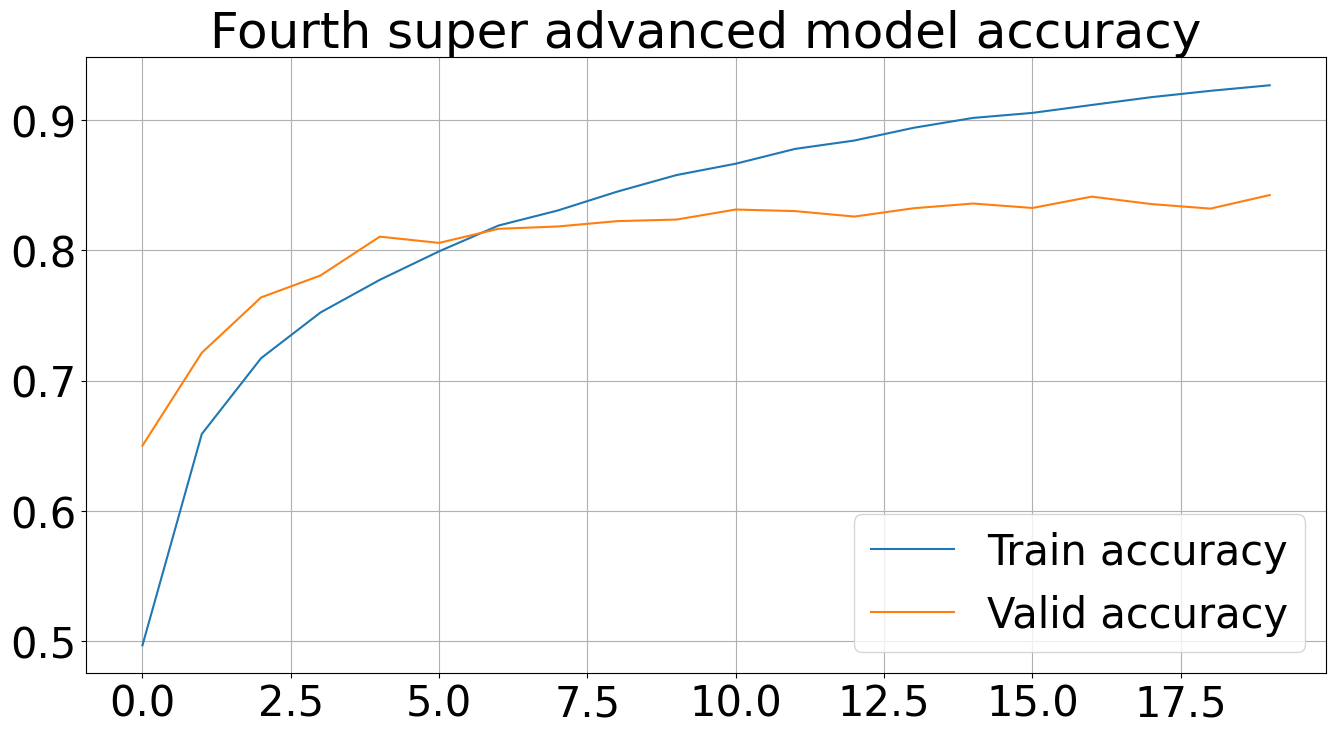

In [36]:
model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Fourth super advanced model')

# Augmentation

for the fourth model, let's try to set up custom data augmentation, random and best learned augmentation and look at the results

In [37]:
train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),#leave the size but scale it
        T.RandomHorizontalFlip(p=0.5), #reflect
        T.RandomAdjustSharpness(sharpness_factor=2),#sharpness
        T.ToTensor(), #tensor
        T.Normalize(mean=means, std=stds) #normalization
    ]
)
#on the test only normalization
test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10('cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

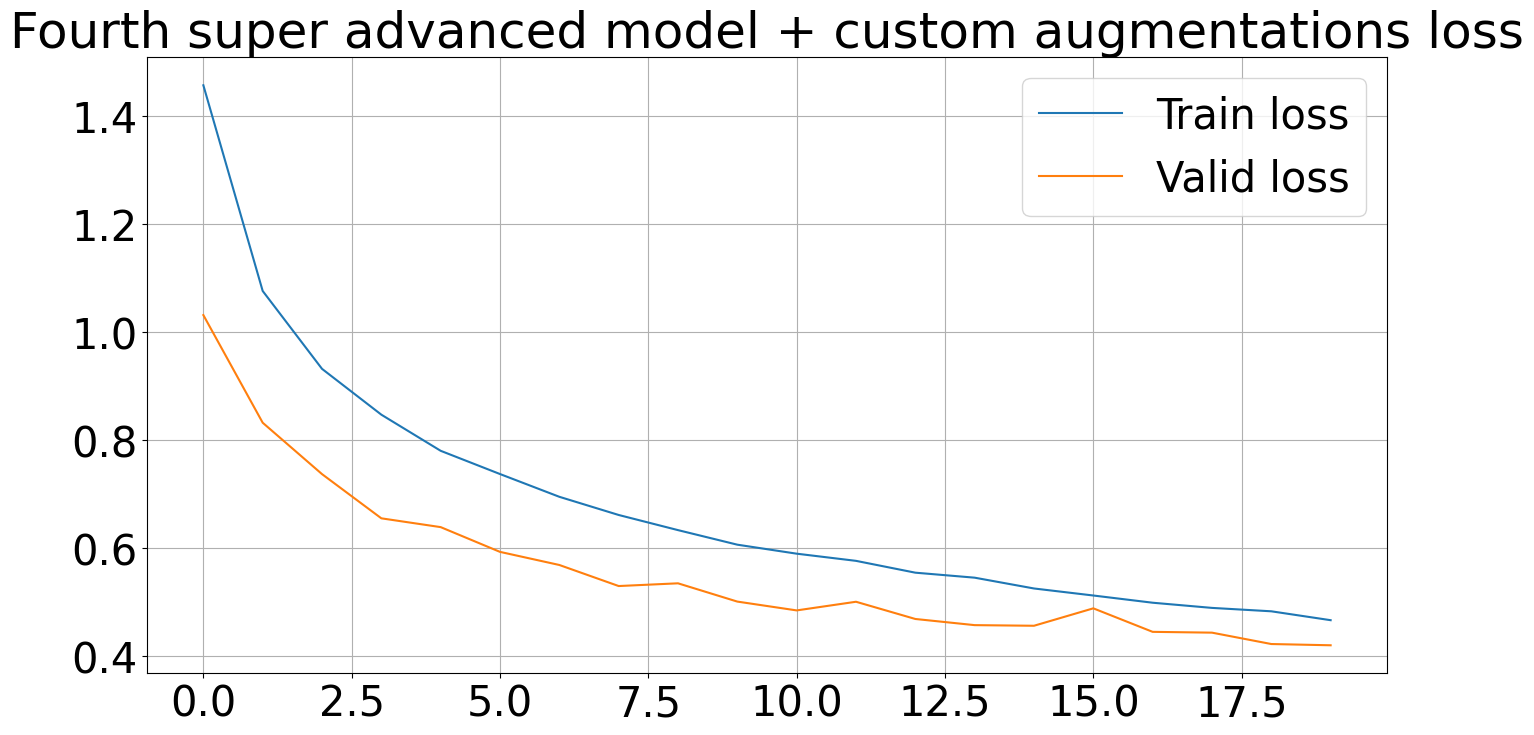

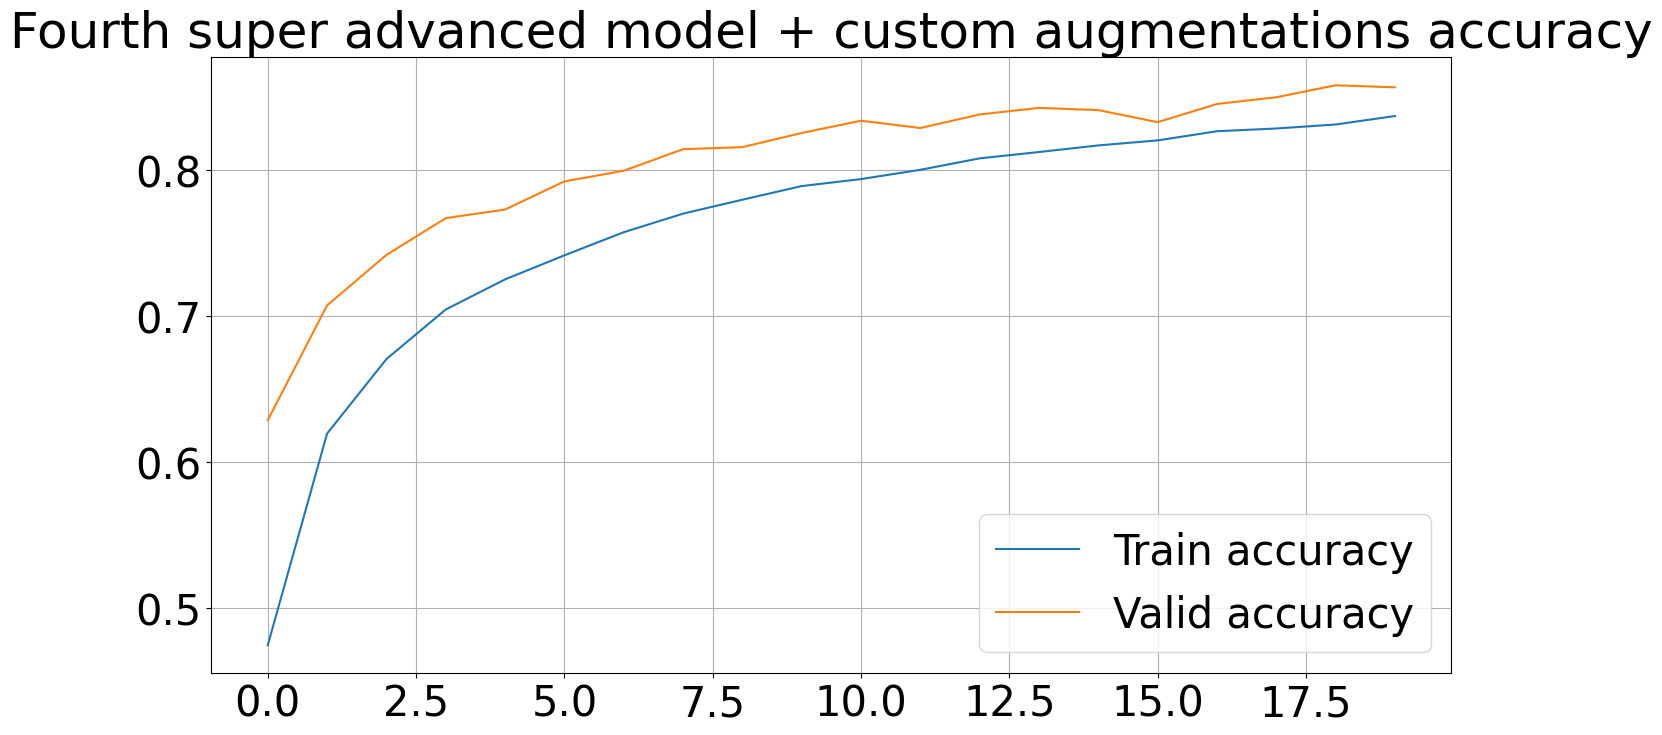

In [38]:
model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Fourth super advanced model + custom augmentations')

In [39]:
train_transforms = T.Compose(
    [
        T.RandAugment(), #random augmentations
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10('cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

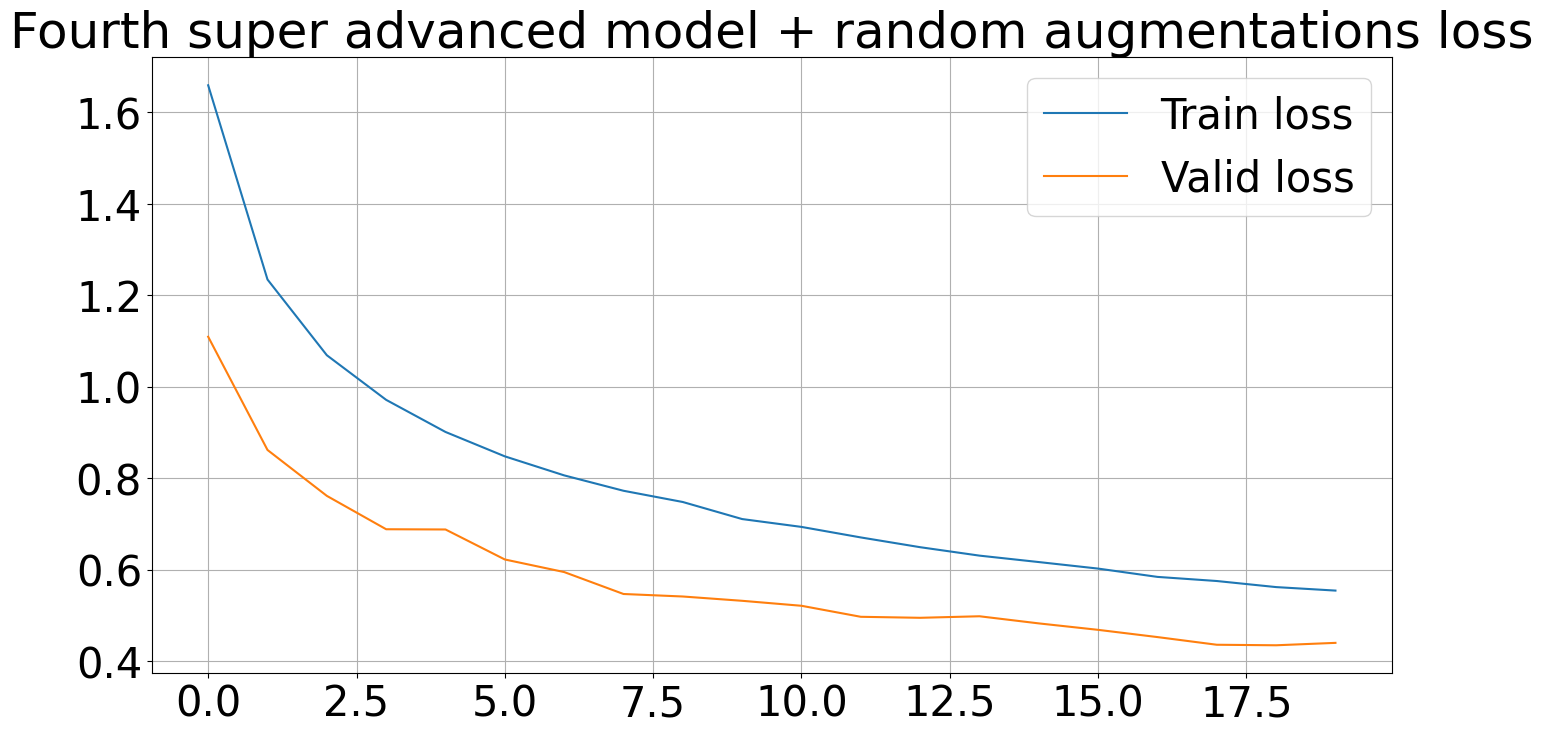

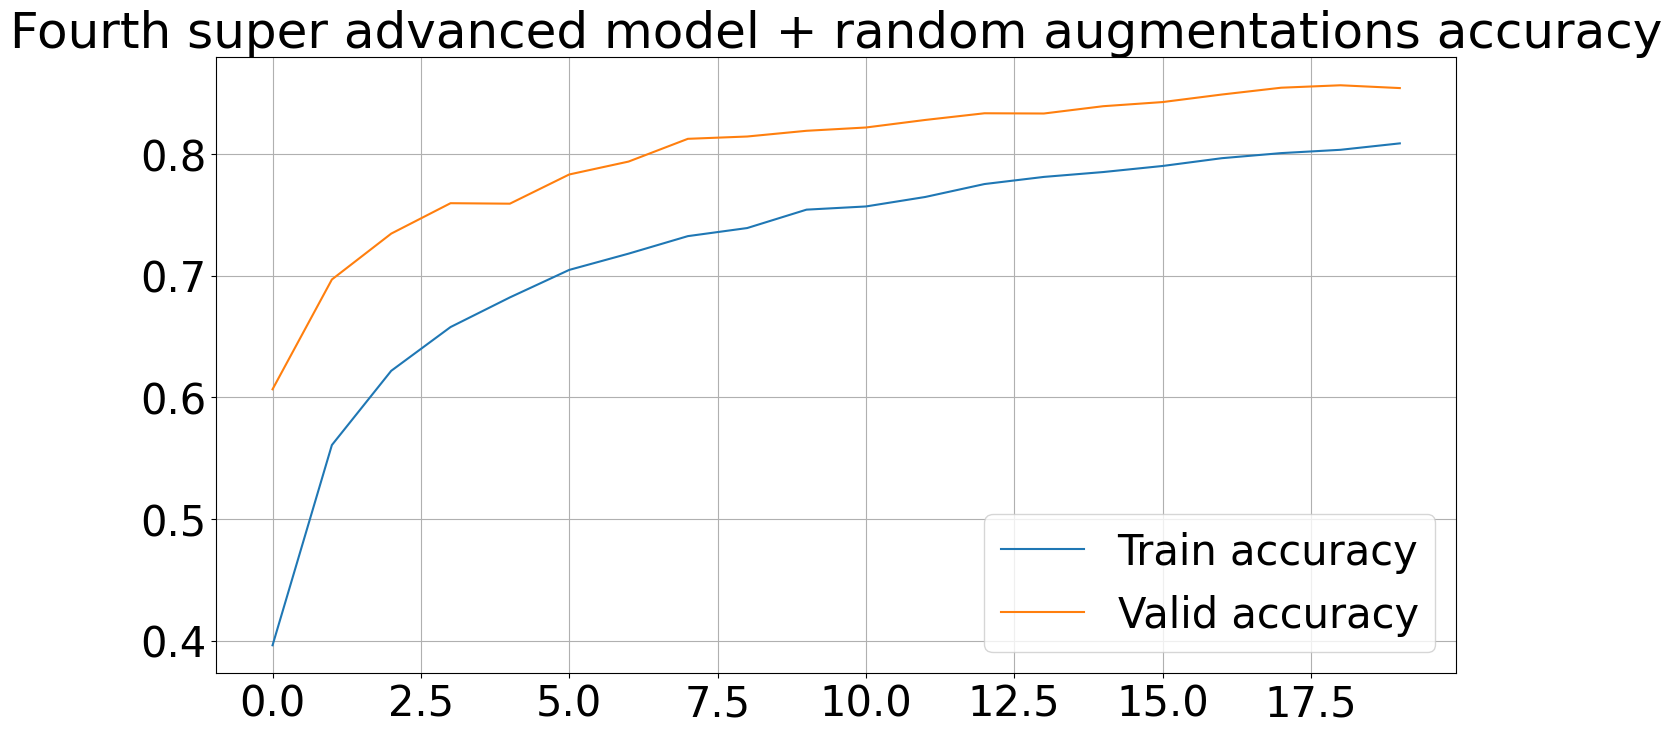

In [40]:
model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Fourth super advanced model + random augmentations')

In [41]:
train_transforms = T.Compose(
    [
        T.AutoAugment(T.AutoAugmentPolicy.CIFAR10), #best learned augmentations
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10('cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

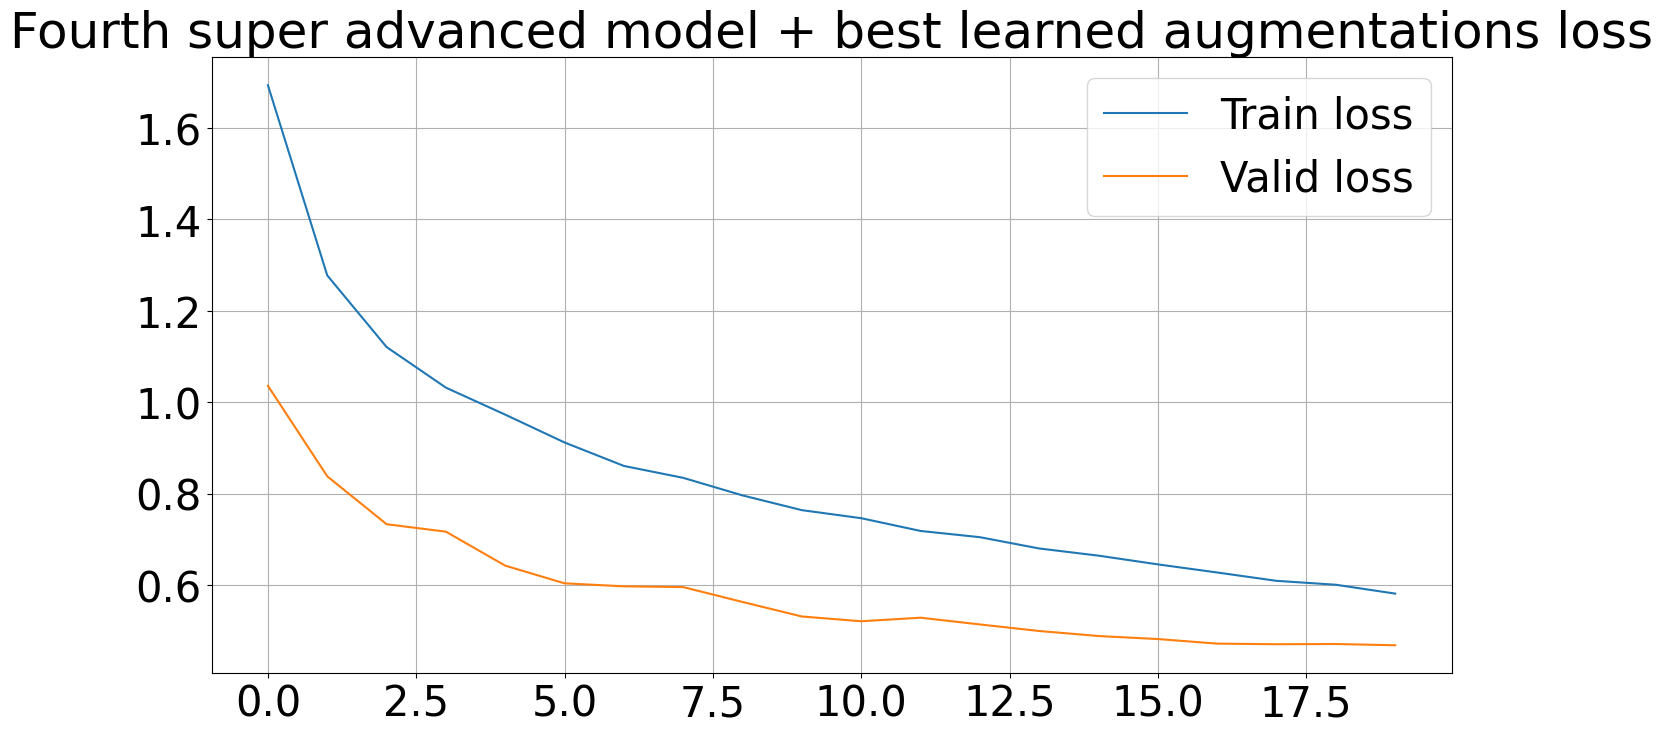

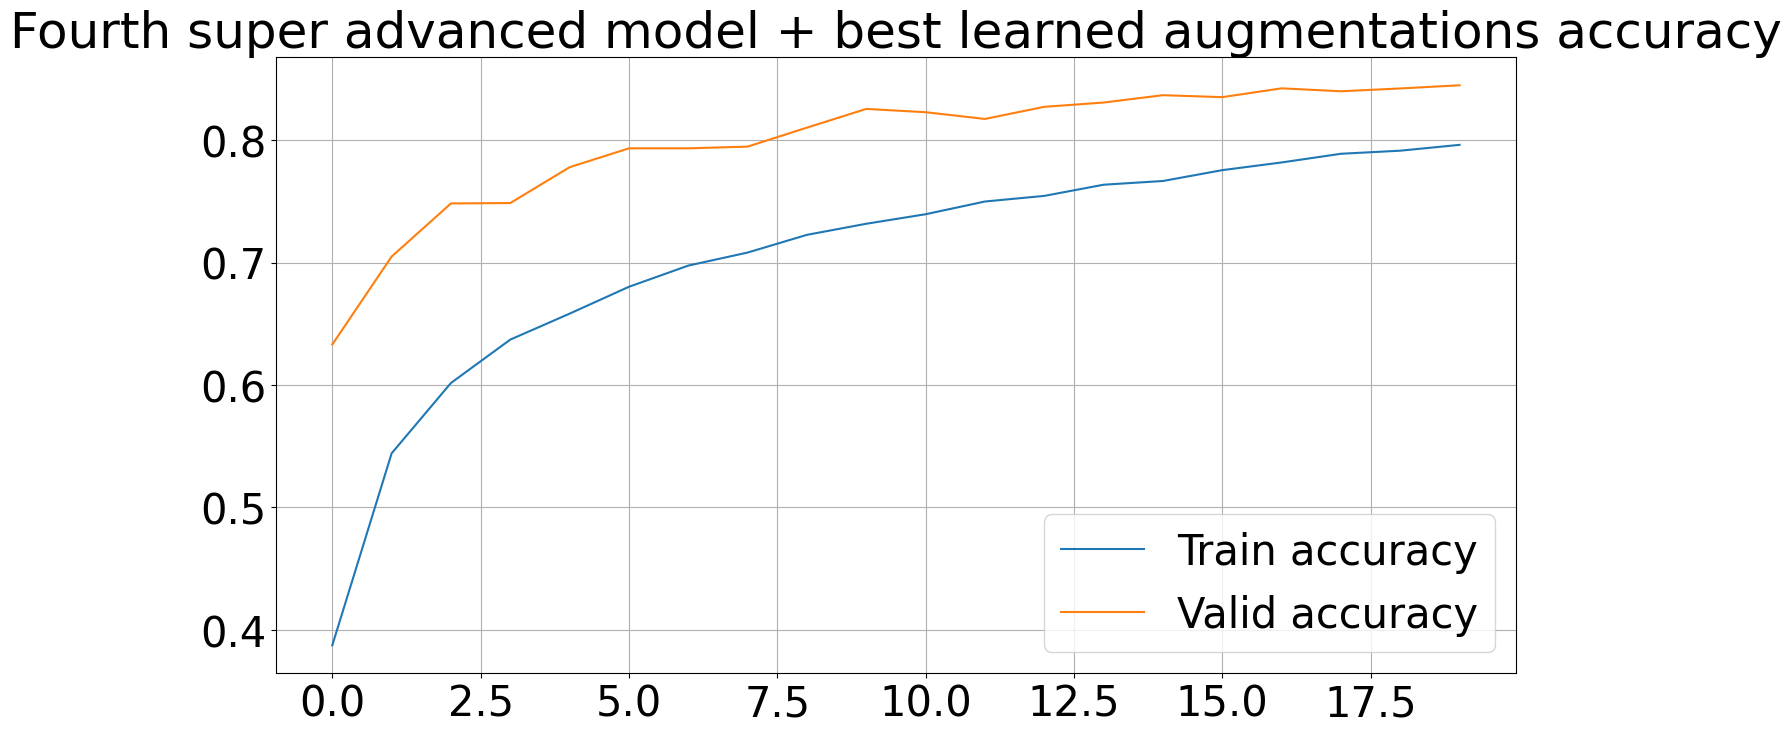

In [42]:
model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Fourth super advanced model + best learned augmentations')

Finally select the fourth model, the best learned augmentations and increase the number of epochs to 40

In [43]:
def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        scheduler.step()

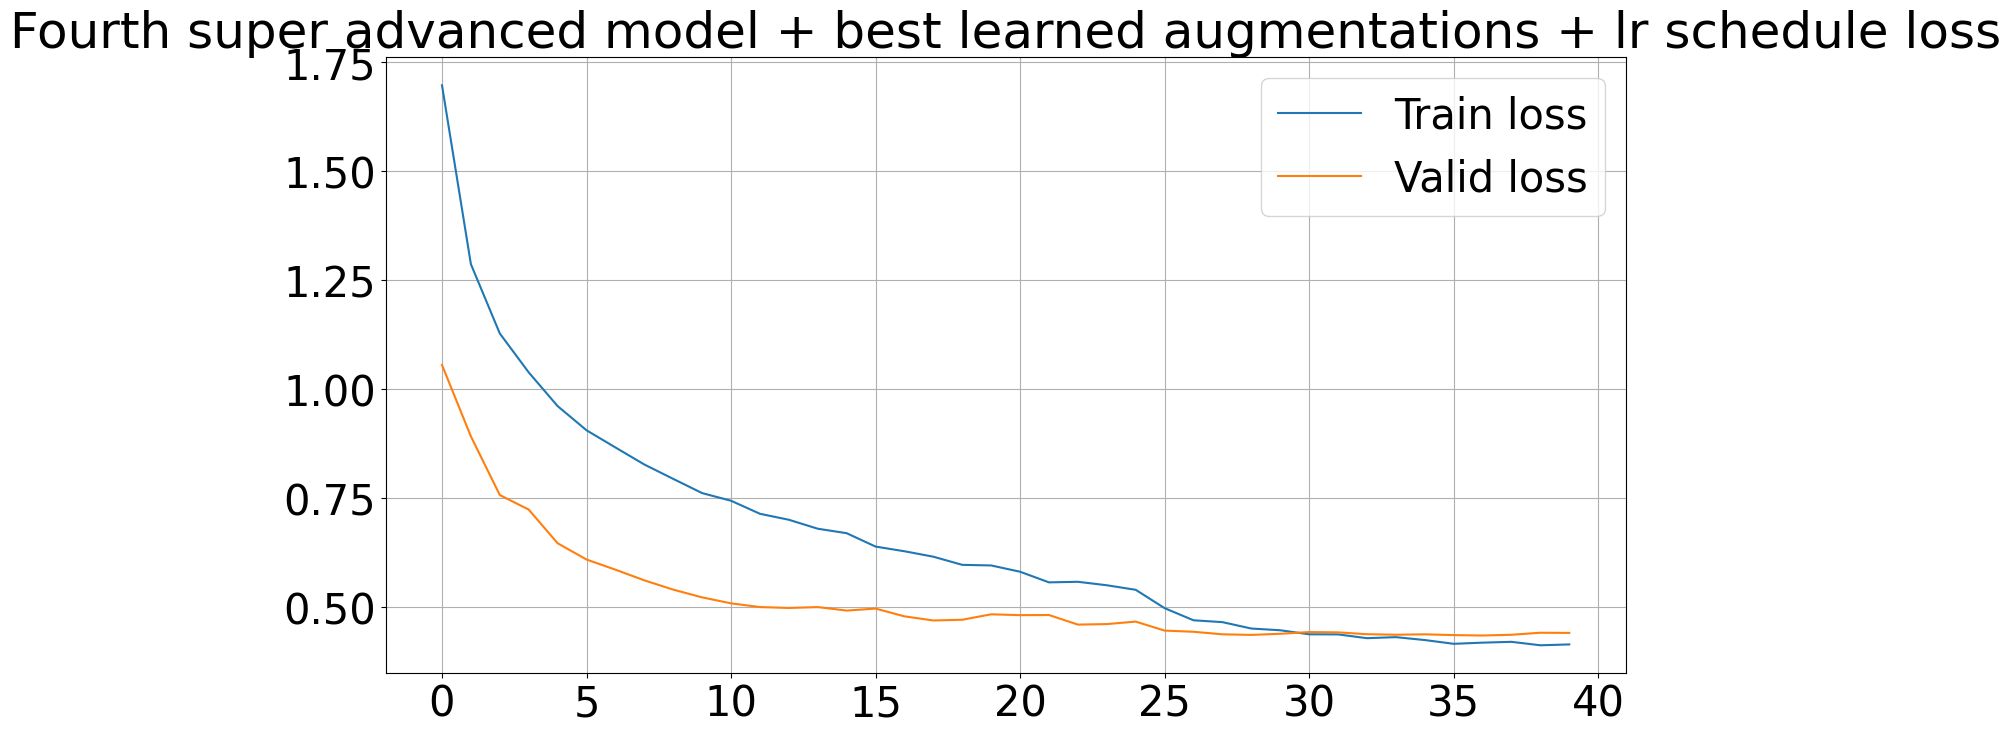

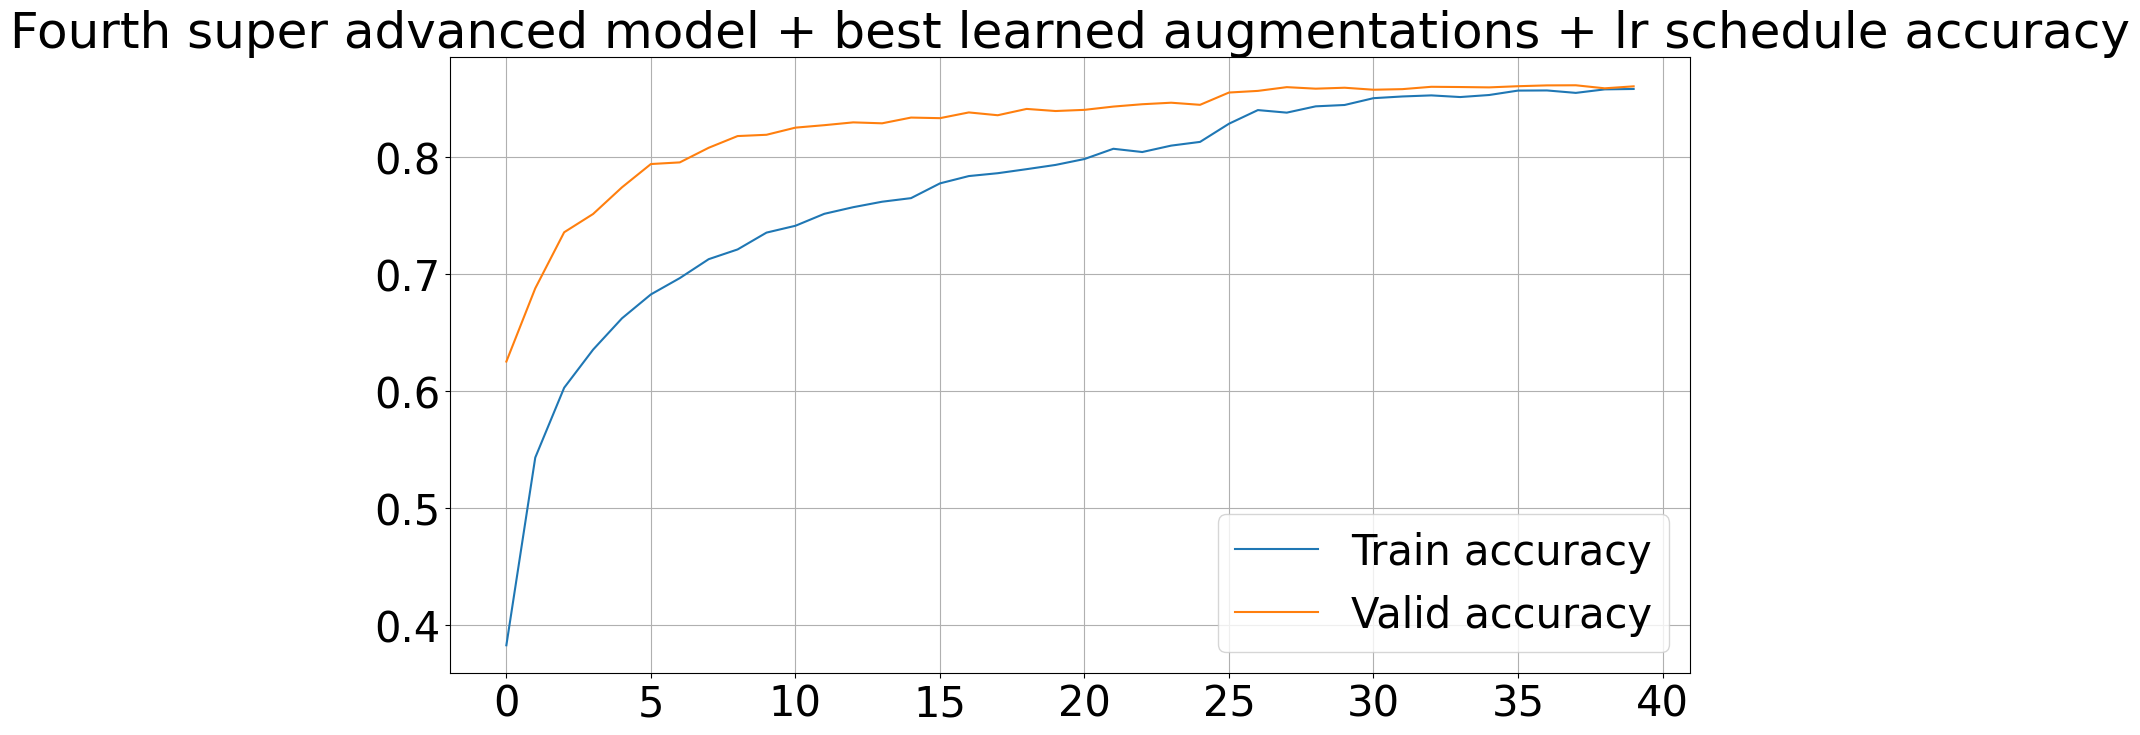

In [44]:
from torch.optim.lr_scheduler import StepLR

model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=25)

whole_train_valid_cycle_with_scheduler(model, 40, 'Fourth super advanced model + best learned augmentations + lr schedule')